# Experiment Nine

## Analysis

In [79]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [80]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# General Utilities
import json
import pprint
import random

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Reading Data and Defining Constants

In [81]:
FILE_NAMES = [
    'raw-data/questions-and-answers-clean.json',
    'raw-data/judgments.json',
    'raw-data/responses-two.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 7
GROUP_SIZE = NUM_QUESTIONS // 2
THRESHOLD = 240.9

CONDITIONS = ['Control', 'Post Number', 'Upvotes']
QUESTIONS = ['Curiosity', 'Confidence', 'Usefulness',
    'Popularity', 'Writing', 'Surprise', 'Social Utility']

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

In [82]:
control_responses = pd.read_pickle('raw-data/control-responses.pkl')
post_responses = pd.read_pickle('raw-data/post-responses.pkl')
upvote_responses = pd.read_pickle('raw-data/upvote-responses.pkl')

upvote_responses.head()

,consent,group_number,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_j2,high_q0_j3,high_q0_j4,high_q0_j5,...,low_q4_j2,low_q4_j3,low_q4_j4,low_q4_j5,low_q4_j6,low_q4_score,participant_id,response_type,test_one,test_two
12,1.0,2,1.0,14.0,3.0,3.0,3.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,50.0,r7gvngs3mjdqo4lb3nd6hm3b3uobqsrb,0,1.0,1.0
49,1.0,2,1.0,23.0,4.0,4.0,2.0,4.0,3.0,3.0,...,4.0,3.0,5.0,4.0,4.0,26.0,3burenqmmt71nbk9sznc0t6gadf8wrlk,0,1.0,1.0
54,1.0,2,1.0,31.0,2.0,1.0,1.0,2.0,3.0,4.0,...,1.0,0.0,3.0,3.0,1.0,18.0,9543ar5qbz3ectkkdqoexf9lurur57za,0,1.0,1.0
77,1.0,2,0.0,25.0,4.0,3.0,3.0,6.0,3.0,6.0,...,4.0,2.0,6.0,3.0,4.0,17.0,hczxorcd6py0pwrty95zbp2rzqdvv66e,0,1.0,1.0
79,1.0,2,0.0,28.0,3.0,4.0,0.0,6.0,5.0,4.0,...,1.0,0.0,4.0,0.0,1.0,17.0,wcoz0wruhmnax6mrrhg3proojyrfved6,0,1.0,1.0


### Intragroup Low/High Rating T-Tests

In [83]:
for data in (control_responses, post_responses, upvote_responses):
    for j_label in JUDGMENT_LABELS:
        low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
        high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
        
        low_data = data[low_headers].mean(axis=1)
        high_data = data[high_headers].mean(axis=1)
        
        data['{}_low'.format(j_label)] = low_data
        data['{}_high'.format(j_label)] = high_data
        data['{}_diff'.format(j_label)] = high_data - low_data

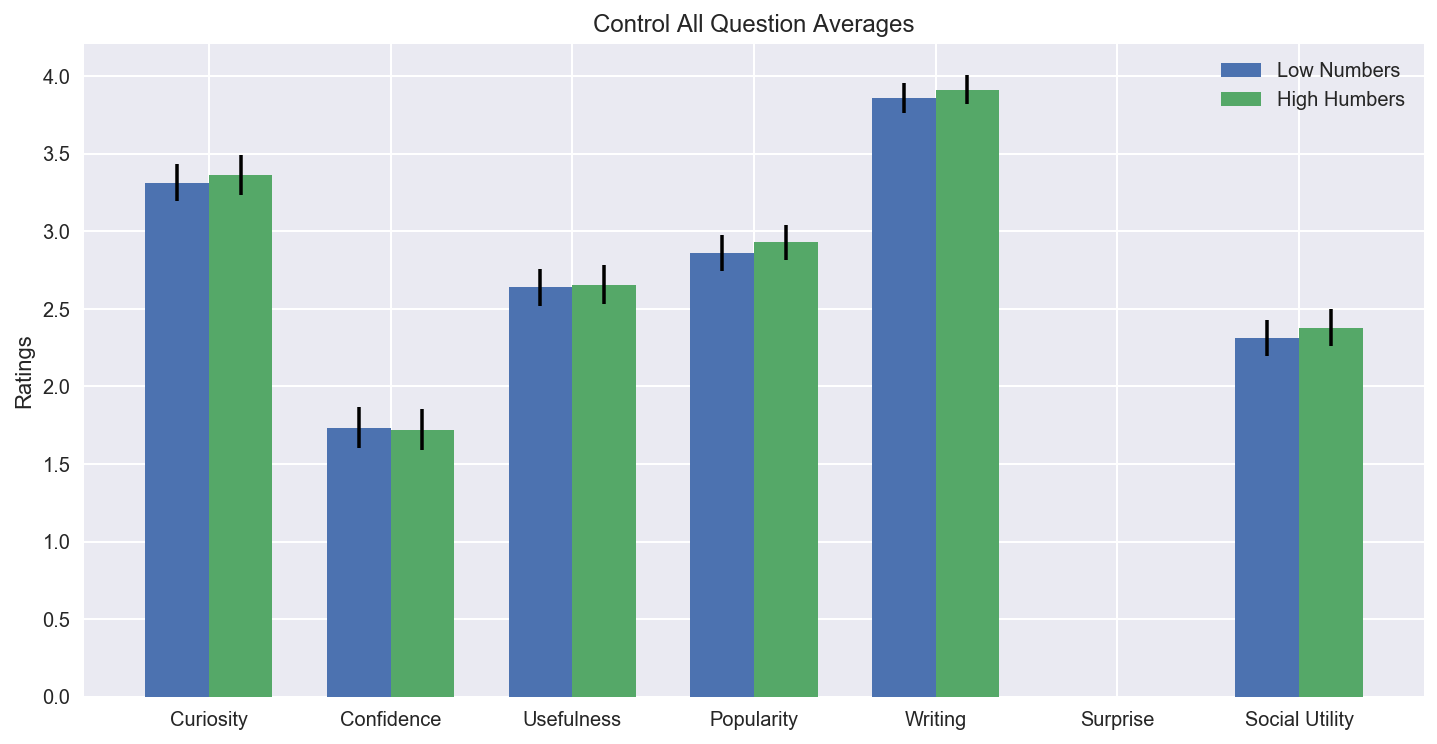

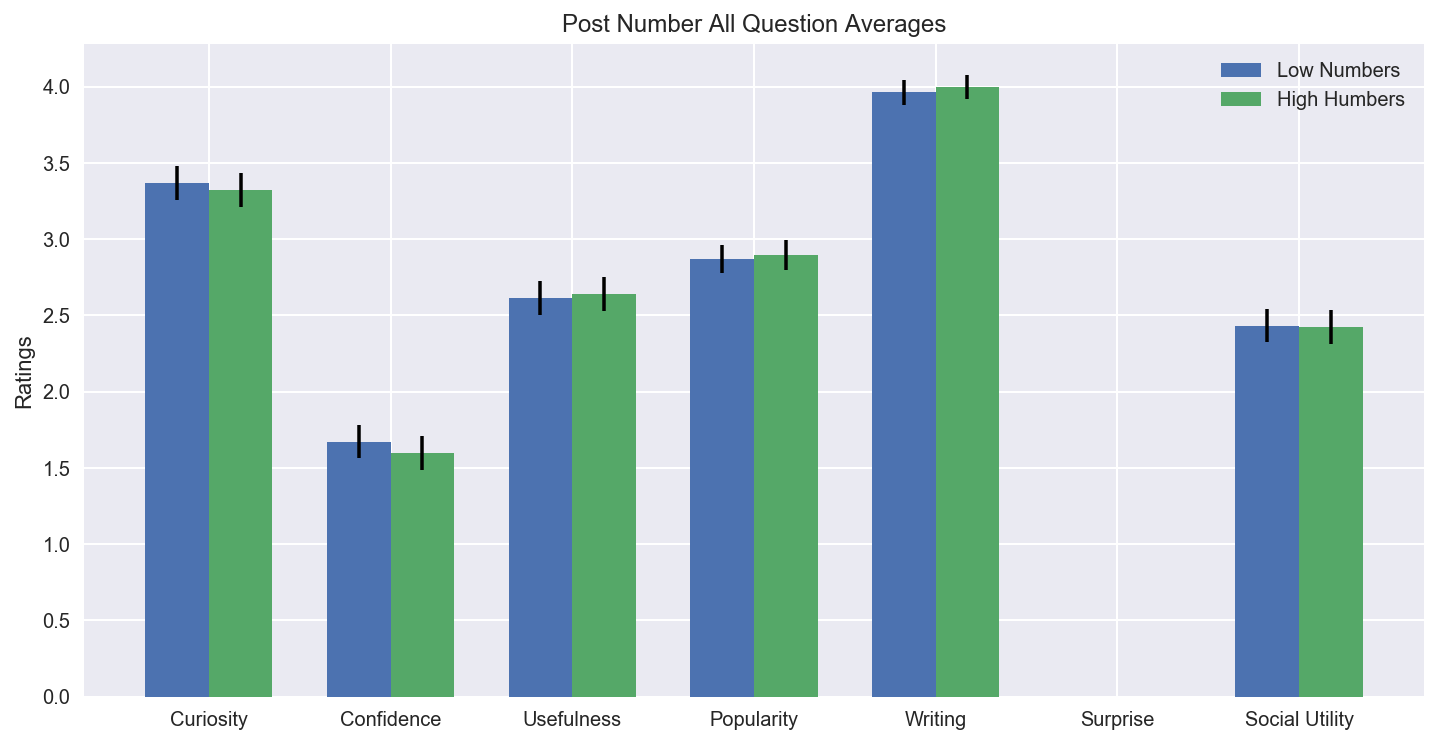

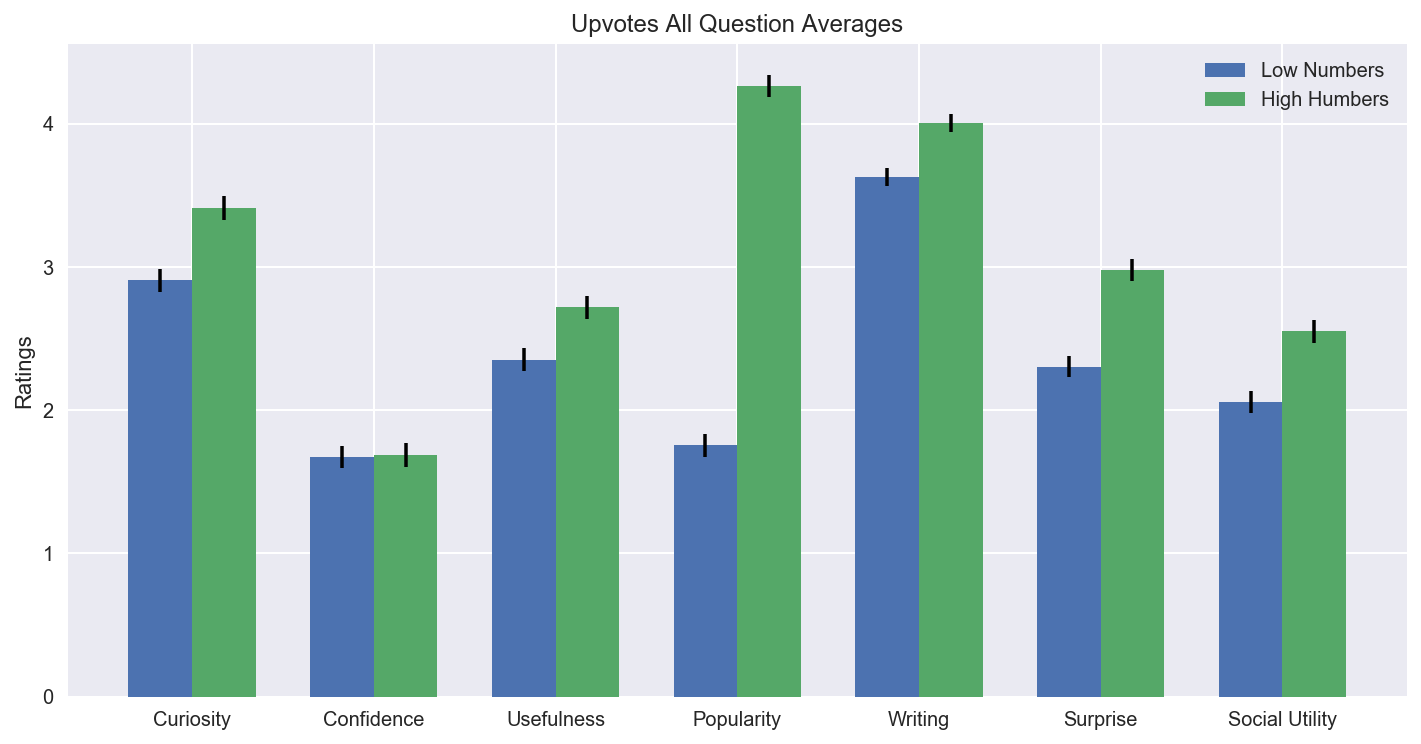

In [101]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low Numbers', 'High Humbers'],
    'size': (12, 6)
}

for name, data in zip(CONDITIONS, (control_responses, post_responses, upvote_responses)):
    low_means, low_errs = [], []
    high_means, high_errs = [], []
    # print(name)
    for j_label in JUDGMENT_LABELS:
        low_data = data['{}_low'.format(j_label)]
        high_data = data['{}_high'.format(j_label)]
        low_means.append(low_data.mean())
        high_means.append(high_data.mean())
        low_errs.append(stats.sem(low_data))
        high_errs.append(stats.sem(high_data))
        # print(low_means); print(high_means)
        # print(low_errs); print(high_errs)
        
    plotting.plot_double_bar(low_means, low_errs, high_means, high_errs,
        **PLOTTING_OPTIONS, title='{} All Question Averages'.format(name))

In [100]:
for name, data in zip(CONDITIONS, (control_responses, post_responses, upvote_responses)):
    print('{}'.format(name))
    for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
        highs = data['{}_high'.format(j_label)]
        lows = data['{}_low'.format(j_label)]
        print('{}: {}, Δ = {:.3f}'.format(
            question,
            describe.paired_t_test(lows, highs),
            highs.mean() - lows.mean()
        ))
    print()

Control
Curiosity: t = -0.546, p = 0.586 (1 greater), Δ = 0.050
Confidence: t = 0.167, p = 0.868 (0 greater), Δ = -0.013
Usefulness: t = -0.209, p = 0.835 (1 greater), Δ = 0.018
Popularity: t = -0.854, p = 0.395 (1 greater), Δ = 0.068
Writing: t = -0.751, p = 0.454 (1 greater), Δ = 0.053
Surprise: t = nan, p = nan (1 greater), Δ = nan
Social Utility: t = -0.999, p = 0.32 (1 greater), Δ = 0.067

Post Number
Curiosity: t = 0.596, p = 0.552 (0 greater), Δ = -0.048
Confidence: t = 1.02, p = 0.31 (0 greater), Δ = -0.072
Usefulness: t = -0.31, p = 0.757 (1 greater), Δ = 0.027
Popularity: t = -0.345, p = 0.73 (1 greater), Δ = 0.028
Writing: t = -0.571, p = 0.569 (1 greater), Δ = 0.035
Surprise: t = nan, p = nan (1 greater), Δ = nan
Social Utility: t = 0.124, p = 0.901 (0 greater), Δ = -0.009

Upvotes
Curiosity: t = -7.28, p = 3.83e-12 (1 greater), Δ = 0.503
Confidence: t = -0.244, p = 0.807 (1 greater), Δ = 0.014
Usefulness: t = -5.8, p = 1.86e-08 (1 greater), Δ = 0.365
Popularity: t = -21.2,

### Intergroup Difference T-Tests

In [86]:
print('Control & Post Number')
for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
    print('{}: {}'.format(question, describe.independent_t_test(
        control_responses['{}_diff'.format(j_label)],
        post_responses['{}_diff'.format(j_label)])))
print()

print('Control & Upvotes')
for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
    print('{}: {}'.format(question, describe.independent_t_test(
        control_responses['{}_diff'.format(j_label)],
        upvote_responses['{}_diff'.format(j_label)])))

Control & Post Number
Curiosity: t = 0.805, p = 0.422 (0 greater)
Confidence: t = 0.554, p = 0.58 (0 greater)
Usefulness: t = -0.0684, p = 0.946 (1 greater)
Popularity: t = 0.346, p = 0.729 (0 greater)
Writing: t = 0.198, p = 0.843 (0 greater)
Surprise: t = nan, p = nan (1 greater)
Social Utility: t = 0.737, p = 0.462 (0 greater)

Control & Upvotes
Curiosity: t = -3.79, p = 0.000178 (1 greater)
Confidence: t = -0.27, p = 0.787 (1 greater)
Usefulness: t = -3.14, p = 0.00183 (1 greater)
Popularity: t = -13.3, p = 2.21e-33 (1 greater)
Writing: t = -3.53, p = 0.000461 (1 greater)
Surprise: t = nan, p = nan (1 greater)
Social Utility: t = -4.44, p = 1.21e-05 (1 greater)


### Intragroup Question Selection

In [87]:
for data in (control_responses, post_responses, upvote_responses):
    low_choice_labels = ['{}_choice'.format(q_label) for q_label in LOW_LABELS]
    high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
    low_choice_means = data[low_choice_labels].mean(axis=1)
    high_choice_means = data[high_choice_labels].mean(axis=1)
    data['low_choice'] = low_choice_means
    data['high_choice'] = high_choice_means

[0.5199999999999999, 0.5100671140939594, 0.44090909090909164]
[0.48000000000000015, 0.48993288590604045, 0.5590909090909086]
[0.014667175952451381, 0.013118257087098972, 0.010866231049344366]
[0.014667175952451381, 0.013118257087098972, 0.010866231049344366]


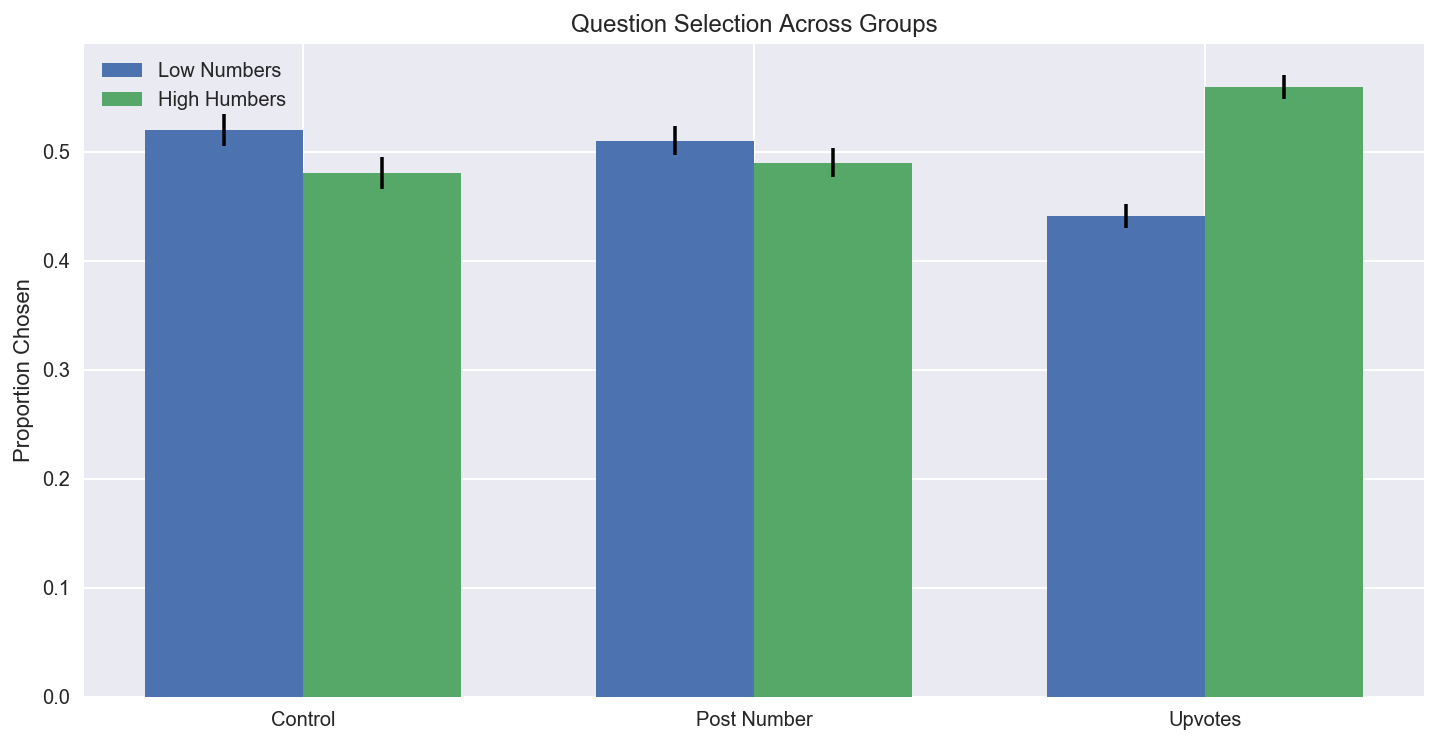

In [104]:
PLOTTING_OPTIONS = {
    'ylabel': 'Proportion Chosen',
    'ticks': ['Control', 'Post Number', 'Upvotes'],
    'legend': ['Low Numbers', 'High Humbers'],
    'size': (12, 6),
    'title': 'Question Selection Across Groups'
}


low_means, low_errs = [], []
high_means, high_errs = [], []
for data in (control_responses, post_responses, upvote_responses):
    low_means.append(data.low_choice.mean())
    high_means.append(data.high_choice.mean())
    low_errs.append(stats.sem(data.low_choice))
    high_errs.append(stats.sem(data.high_choice))

print(low_means, high_means, low_errs, high_errs, sep='\n')

plotting.plot_double_bar(low_means, low_errs, high_means, high_errs,
        **PLOTTING_OPTIONS)

In [89]:
for name, data in zip(CONDITIONS, (control_responses, post_responses, upvote_responses)):
    print('{}: {}, Δ = {:.3}'.format(
        name,
        describe.one_sample_t_test(data.high_choice, 0.5),
        data.high_choice.mean() - 0.5
    ))

Control: t = -1.36, p = 0.175 (smaller), Δ = -0.02
Post Number: t = -0.767, p = 0.444 (smaller), Δ = -0.0101
Upvotes: t = 5.44, p = 1.23e-07 (greater), Δ = 0.0591


### Per Question Analysis

In [90]:
non_upvote_responses = pd.concat([control_responses, post_responses])

In [91]:
COLUMN_NAMES = [
    'curiosity', 'confidence', 'usefulness',
    'popularity', 'writing', 'surprise', 'social_utility',
    'group', 'number', 'choice']
flattened_data = {col: [] for col in COLUMN_NAMES}

for index, row in non_upvote_responses.iterrows():
    for q_label in ALL_LABELS:
        for number, col_name in enumerate(COLUMN_NAMES[:-3]):
            flattened_data[col_name].append(
                row['{}_j{}'.format(q_label, number)])
    
        choice_info = row['{}_choice'.format(q_label)]
        index_info = row['{}_index'.format(q_label)]
        
        flattened_data['choice'].append(choice_info)
        flattened_data['number'].append(index_info)
        flattened_data['group'].append('none')
        
for index, row in upvote_responses.iterrows():
    for q_num, q_label in enumerate(ALL_LABELS):
        for number, col_name in enumerate(COLUMN_NAMES[:-3]):
            flattened_data[col_name].append(
                row['{}_j{}'.format(q_label, number)])
            
        choice_info = row['{}_choice'.format(q_label)]
        index_info = row['{}_index'.format(q_label)]
        group_info = 'high' if q_num > GROUP_SIZE else 'low'
        
        flattened_data['choice'].append(choice_info)
        flattened_data['number'].append(index_info)
        flattened_data['group'].append(group_info)

In [92]:
question_data = pd.DataFrame(flattened_data)
print(len(question_data),
      len(upvote_responses) + len(non_upvote_responses))
question_data.head()

5330 533


,choice,confidence,curiosity,group,number,popularity,social_utility,surprise,usefulness,writing
0,1.0,4.0,3.0,none,7.0,4.0,3.0,NaN,4.0,4.0
1,0.0,2.0,3.0,none,33.0,2.0,3.0,NaN,2.0,3.0
2,1.0,3.0,3.0,none,43.0,4.0,3.0,NaN,4.0,4.0
3,1.0,4.0,3.0,none,22.0,3.0,3.0,NaN,3.0,4.0
4,0.0,2.0,3.0,none,48.0,3.0,2.0,NaN,3.0,2.0


In [93]:
low_questions = question_data[question_data.group == 'low']
high_questions = question_data[question_data.group == 'high']
none_questions = question_data[question_data.group == 'none']

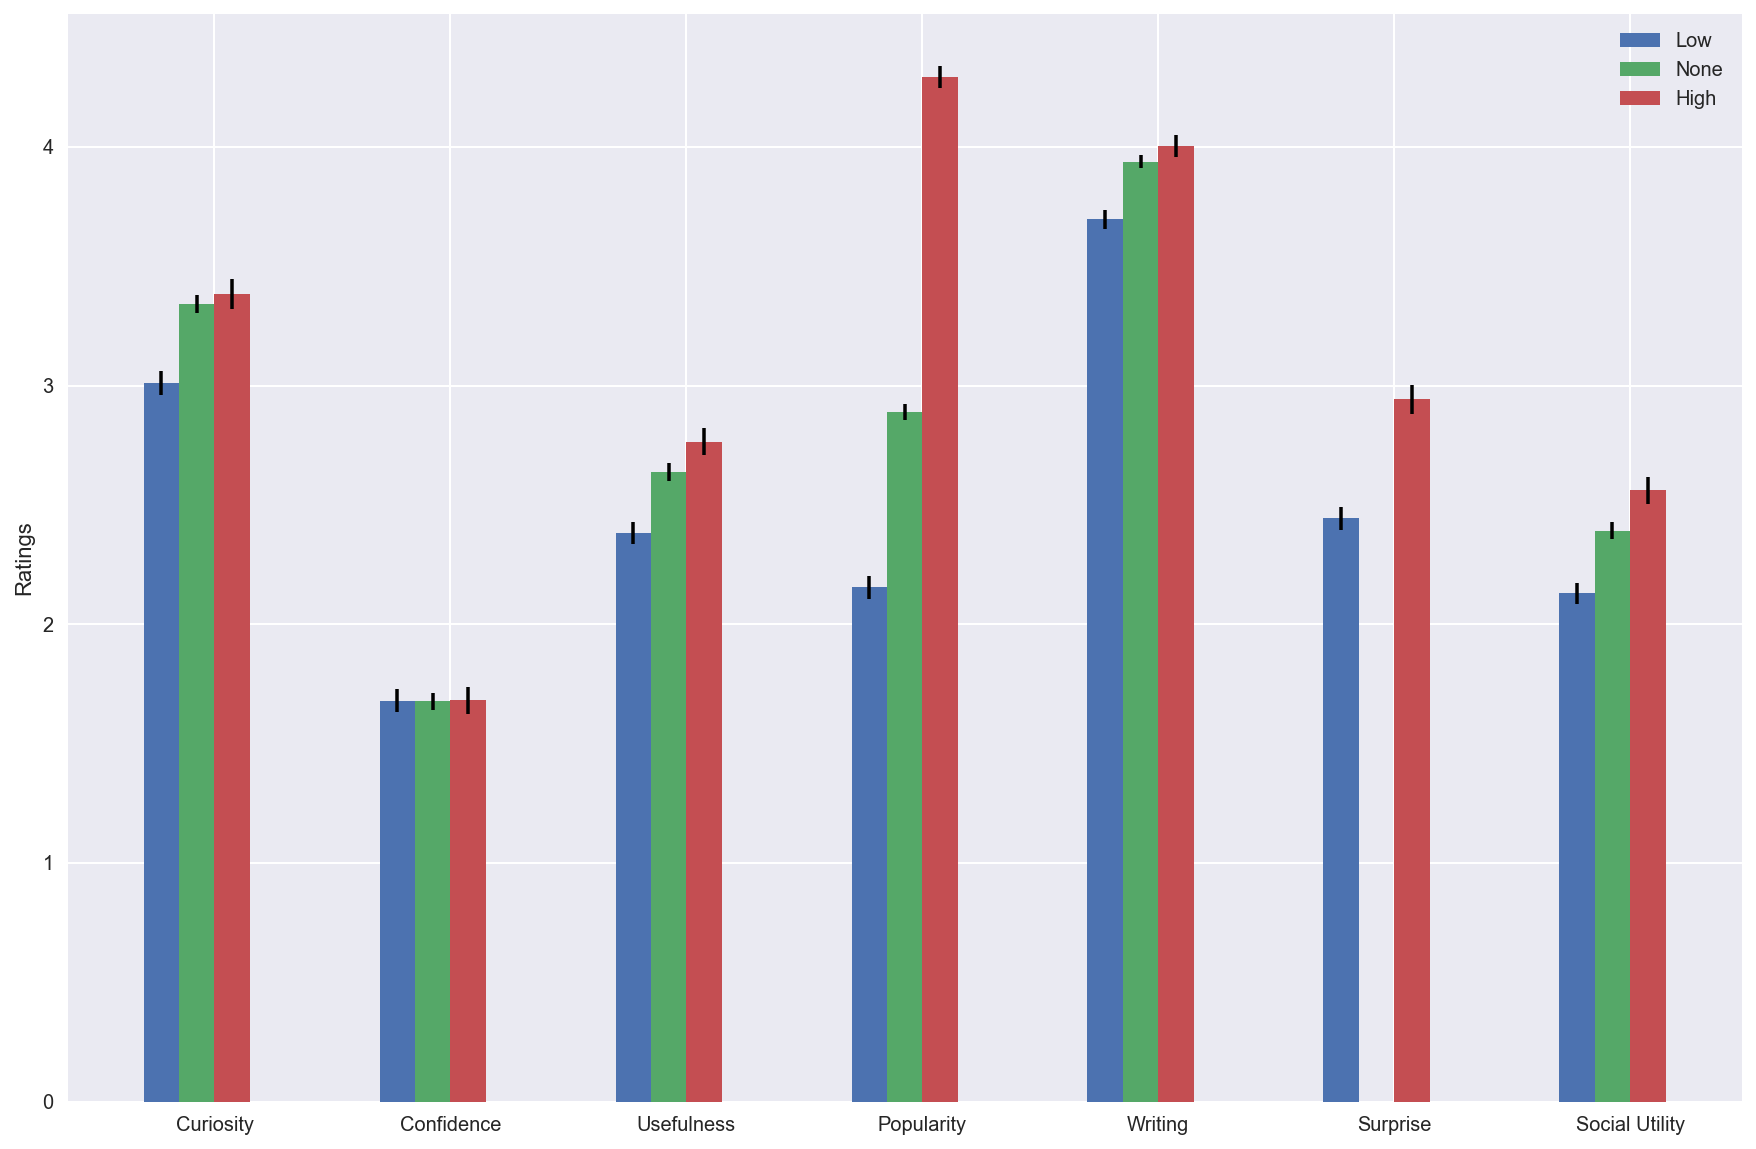

In [94]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low', 'None', 'High'],
    'size': (15, 10)
}

low_means, low_errs = [], []
none_means, none_errs = [], []
high_means, high_errs = [], []

for judgment in COLUMN_NAMES[:7]:
    low_means.append(low_questions[judgment].mean())
    none_means.append(none_questions[judgment].mean())
    high_means.append(high_questions[judgment].mean())
    
    low_errs.append(stats.sem(low_questions[judgment]))
    none_errs.append(stats.sem(none_questions[judgment]))
    high_errs.append(stats.sem(high_questions[judgment]))

plotting.plot_triple_bar(low_means, low_errs, none_means, none_errs, 
                         high_means, high_errs, **PLOTTING_OPTIONS)

### Question Choice Prediction

In [95]:
upvote_question_data = question_data[(question_data.group == 'high') |
                                     (question_data.group == 'low')]

In [96]:
all_predictors = [
    'curiosity', 'confidence', 'usefulness', 'popularity',
    'writing', 'surprise', 'social_utility'
]
X = upvote_question_data[all_predictors]
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.611326
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2640
Model:                          Logit   Df Residuals:                     2632
Method:                           MLE   Df Model:                            7
Date:                Sun, 03 Jun 2018   Pseudo R-squ.:                  0.1180
Time:                        12:13:55   Log-Likelihood:                -1613.9
converged:                       True   LL-Null:                       -1829.9
                                        LLR p-value:                 3.228e-89
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1851      0.136     -8.715      0.000      -1.452      -0.919
curiosity          0.3361      0.029     11.489      0.000       0.279       0.393
confidence        -0.0913      0.025     -3.647      0.000      -0.140      -0.042
usefulness         0.1150      0.036      3.156      0.002       0.044       0.186
popularity         0.0763      0.023      3.257      0.001       0.030       0.122
writing           -0.0072      0.031     -0.235      0.814      -0.067       0.053
surprise          -0.0774      0.023     -3.346      0.001      -0.123      -0.032
social_utility    -0.0065      0.037     -0.175      0.861      -0.079       0.066
==================================================================================
"""

### Mediation of Popularity by Curiousity in Question Choice

In [97]:
# Popularity
X = upvote_question_data['popularity']
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
display(results.summary())

# Curiosity
X = upvote_question_data['curiosity']
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
display(results.summary())

# Both
X = upvote_question_data[['popularity', 'curiosity']]
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
display(results.summary())

Optimization terminated successfully.
         Current function value: 0.676777
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2640
Model:                          Logit   Df Residuals:                     2638
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Jun 2018   Pseudo R-squ.:                 0.02362
Time:                        12:13:55   Log-Likelihood:                -1786.7
converged:                       True   LL-Null:                       -1829.9
                                        LLR p-value:                 1.443e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5427      0.071     -7.616      0.000      -0.682      -0.403
popularity     0.1803      0.020      9.168      0.000       0.142       0.219
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.619376
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2640
Model:                          Logit   Df Residuals:                     2638
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Jun 2018   Pseudo R-squ.:                  0.1064
Time:                        12:13:55   Log-Likelihood:                -1635.2
converged:                       True   LL-Null:                       -1829.9
                                        LLR p-value:                 1.056e-86
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2978      0.083    -15.671      0.000      -1.460      -1.135
curiosity      0.4080      0.022     18.404      0.000       0.365       0.452
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.617812
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2640
Model:                          Logit   Df Residuals:                     2637
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Jun 2018   Pseudo R-squ.:                  0.1087
Time:                        12:13:55   Log-Likelihood:                -1631.0
converged:                       True   LL-Null:                       -1829.9
                                        LLR p-value:                 4.219e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4220      0.094    -15.094      0.000      -1.607      -1.237
popularity     0.0636      0.022      2.880      0.004       0.020       0.107
curiosity      0.3869      0.023     16.667      0.000       0.341       0.432
==============================================================================
"""

In [98]:
JUDGMENT_LABELS

['j0', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']